In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from camelyon.losses import ranknet_loss


y_true = torch.tensor([[1, 1, 0, 0]], dtype=torch.float32)
y_prob = torch.tensor([[0.5, 0.5, 0.0, 0.0]], dtype=torch.float32)

ranknet_loss(y_prob, y_true, device="cpu", num_neg=3, num_pos=3)

torch.Size([1, 4]) torch.Size([1, 4])


tensor(0.1269)

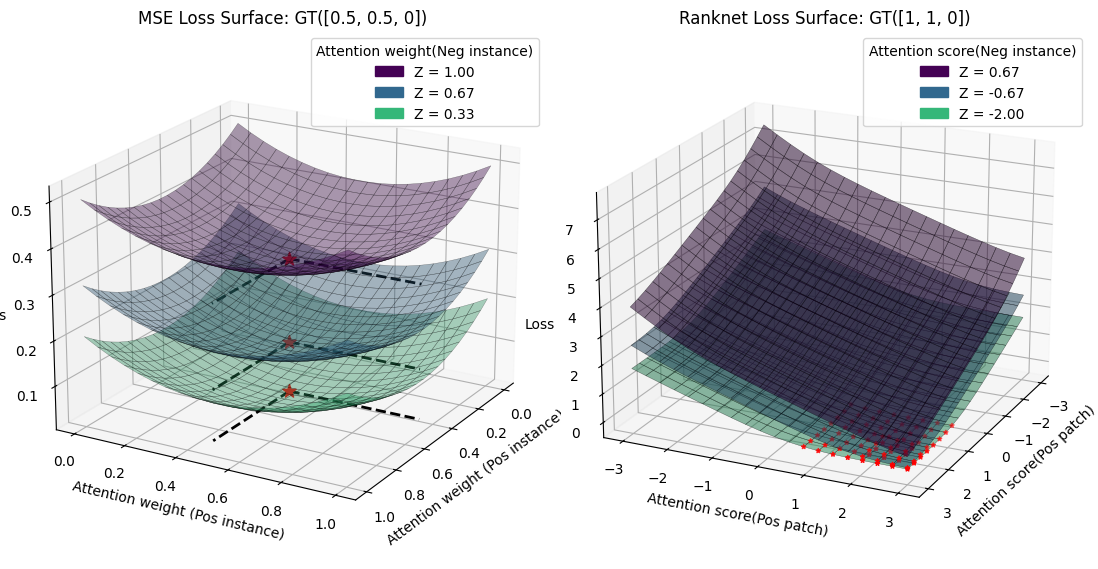

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from camelyon.losses import ranknet_loss

# Create 3D subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 9), subplot_kw={"projection": "3d"})
colormaps = plt.cm.viridis(np.linspace(0, 1, 4))


# Subplot 0    
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)
z_vals = np.linspace(0, 1, 4)[::-1][:-1]
X, Y = np.meshgrid(x_vals, y_vals)
mse_legend_patches = []
for idx, z_val in enumerate(z_vals):
    mse_values = np.zeros((len(x_vals), len(y_vals)))
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            y_prob = torch.tensor([x, y, z_val], dtype=torch.float32)
            y_true = torch.tensor([0.5, 0.5, 0.0], dtype=torch.float32)
            mse_values[i, j] = torch.nn.functional.mse_loss(y_prob, y_true).item()
            
    surf = axes[0].plot_surface(X, Y, mse_values.T, color=colormaps[idx], alpha=0.4, edgecolor='k', linewidth=0.3)
    mse_legend_patches.append(mpatches.Patch(color=colormaps[idx], label=f"Z = {z_val:.2f}"))

optimal_points = []
for z_val in z_vals:
    y_prob = torch.tensor([0.5, 0.5, z_val], dtype=torch.float32)
    y_true = torch.tensor([0.5, 0.5, 0.0], dtype=torch.float32)
    loss_value = torch.nn.functional.mse_loss(y_prob, y_true).item()
    optimal_points.append((0.5, 0.5, loss_value, z_val))  # (x, y, loss, z)

# 최적 지점 산점도 추가
for x, y, loss, z in optimal_points:
    axes[0].scatter(x, y, loss, color='red', s=100, marker='*', edgecolor='red', label=f'Opt. at Z={z:.2f}', alpha=1.0)
    axes[0].plot([x, 1], [y, y], [loss, loss], linestyle='dashed', color='black', linewidth=2)
    axes[0].plot([x, x], [y, 1], [loss, loss], linestyle='dashed', color='black', linewidth=2)
    
axes[0].view_init(elev=20, azim=30)  # Adjust elevation and azimuth
axes[0].set_title('MSE Loss Surface: GT([0.5, 0.5, 0])')
axes[0].set_xlabel('Attention weight (Pos instance)')
axes[0].set_ylabel('Attention weight (Pos instance)')
axes[0].set_zlabel('Loss')
axes[0].legend(handles=mse_legend_patches, loc='upper right', title="Attention weight(Neg instance)")

# Subplot 1
x_vals = np.linspace(-3, 3, 20)
y_vals = np.linspace(-3, 3, 20)
z_vals = np.linspace(-2, 2, 4)[::-1][1:]
X, Y = np.meshgrid(x_vals, y_vals)
margin = 2.5
ranknet_legend_patches = []
for idx, z_val in enumerate(z_vals):
    loss_values = np.zeros((len(x_vals), len(y_vals)))
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            y_prob = torch.tensor([x, y, z_val], dtype=torch.float32)
            y_true_rank = torch.tensor([1.0, 1.0, 0.0], dtype=torch.float32)
            loss_values[i, j] = ranknet_loss(y_prob, y_true_rank, sigma=2.0, device="cpu", margin=margin).item()
    surf = axes[1].plot_surface(X, Y, loss_values.T, color=colormaps[idx], alpha=0.4, edgecolor='k', linewidth=0.3)
    ranknet_legend_patches.append(mpatches.Patch(color=colormaps[idx], label=f"Z = {z_val:.2f}"))

# 최적 영역 마스킹 및 시각화
for idx, z_val in enumerate(z_vals):
    loss_values = np.zeros((len(x_vals), len(y_vals)))
    optimal_mask = np.zeros_like(loss_values, dtype=bool)  # 최적 영역 마스크

    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            y_prob = torch.tensor([x, y, z_val], dtype=torch.float32)
            y_true_rank = torch.tensor([1.0, 1.0, 0.0], dtype=torch.float32)
            loss_values[i, j] = ranknet_loss(y_prob, y_true_rank, sigma=2.0, device="cpu", margin=margin).item()

            # 최적 영역 (x, y > z) 체크
            if x > z_val + margin and y > z_val + margin:
                optimal_mask[i, j] = True  # 최적 영역 표시

    # Surface Plot (기본 RankNet 손실)
    surf = axes[1].plot_surface(X, Y, loss_values.T, color=colormaps[idx], alpha=0.2, edgecolor='k', linewidth=0.3)

    # 최적 영역 강조 (별도 색상 추가)
    optimal_x, optimal_y = X[optimal_mask], Y[optimal_mask]
    optimal_loss = loss_values.T[optimal_mask]
    axes[1].scatter(optimal_x, optimal_y, optimal_loss, color='red', s=10, marker='*', label=f'Optimal Region (Z={z_val:.2f})')

# 레전드 추가
handles, labels = axes[1].get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
axes[1].legend(unique_labels.values(), unique_labels.keys(), loc='upper right', title="Attention score (Neg instance)")


axes[1].view_init(elev=20, azim=25)  # Adjust elevation and azimuth
axes[1].set_title('Ranknet Loss Surface: GT([1, 1, 0])')
axes[1].set_xlabel('Attention score(Pos patch)')
axes[1].set_ylabel('Attention score(Pos patch)')
axes[1].set_zlabel('Loss')
axes[1].legend(handles=ranknet_legend_patches, loc='upper right', title="Attention score(Neg instance)")

plt.tight_layout()